In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Market Regime

A ideia é construir um modelo (ou indicador) capaz de detectar mudanças no regime do mercado de renda variável 
quando este muda de um estado de **baixa** para **media ou alta** volatilidade.

Para fins de ilustração, a Figura a seguir mostra as séries históricas de preço e de variações percentuais 
diárias, de 2000 a 2020, do índice americano S&P500. 


In [3]:
v_directory = 'DataSets/'

In [4]:
v_sp500 = pd.read_csv(v_directory + 'S&P500.csv', parse_dates=True)
v_sp500['Date'] = pd.to_datetime(v_sp500['Date'], infer_datetime_format=True)
v_sp500.index = v_sp500['Date'].values
v_sp500.sort_index(inplace=True)
v_sp500.dropna(thresh=4, axis=0, inplace=True)
v_sp500.info()

#v_sp500.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5084 entries, 2000-01-03 to 2020-03-18
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5084 non-null   datetime64[ns]
 1   Open       5084 non-null   float64       
 2   High       5084 non-null   float64       
 3   Low        5084 non-null   float64       
 4   Close      5084 non-null   float64       
 5   Adj Close  5084 non-null   float64       
 6   Volume     5084 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 317.8 KB


In [5]:
#v_sp500.tail()

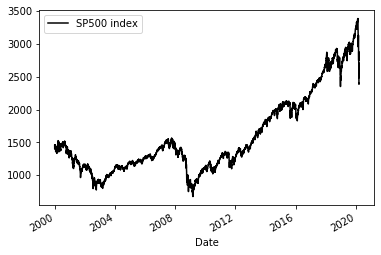

In [6]:
v_sp500['Close'].plot(style='k', label='SP500 index')
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

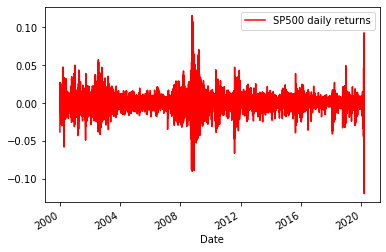

In [7]:
v_sp500['Close'].pct_change().plot(style='r', label='SP500 daily returns')
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [8]:
#v_sp500['Close'].pct_change()

Observe que a série de retornos diários carrega algumas informações que não parecem tão evidentes 
na série de preços. Ao longo de todo o período vemos oscilações na faixa de 1.5% a 3.0% ao dia, 
tanto em níveis positivos quanto negativos, acompanhados de algumas casos mais extremos fora dessa faixa.
O estados de **média** e **alta volatilidade** estão associados a estas oscilações mais extremas que ocorrem 
**fora da faixa** de normalidade.

Durante os períodos de crise sistêmica, como em 2008 e também em 2020, percebe-se um aumento 
significativo na magnitude das oscilações diárias - com variações da ordem de 10% ao dia. Nesses períodos, 
grandes perdas inicias geralmente vêm acompanhadas de repiques e correções às estas perdas.  
 
Para cada uma dessas grandes oscilações podemos tentar construir uma explicação lógica ou apresentar um 
fato macroeconômico ou geopolítico, mas na verdade grande parte delas são meramente 
resultados da atuação excessiva dos agentes no mercado. O fato é que estados anormais de volatilidade 
refletem incerteza trazendo maior risco para a tomada de decisão do investidor.

O mercado de renda variável americano possui um indice que reflete a volatilidade esperada do índice S&P500: 
**CBOE - VIX**. Ver gráfico a seguir. 


In [9]:
v_vix = pd.read_csv(v_directory + 'VIX.csv', parse_dates=True)
v_vix['Date'] = pd.to_datetime(v_vix['Date'], infer_datetime_format=True)
v_vix.index = v_sp500['Date'].values
v_vix.sort_index(inplace=True)
v_vix = v_vix.drop(columns=['Volume'])
v_vix.dropna(thresh=4, axis=0, inplace=True)
v_vix.info()

#v_vix.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5084 entries, 2000-01-03 to 2020-03-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5084 non-null   datetime64[ns]
 1   Open       5084 non-null   float64       
 2   High       5084 non-null   float64       
 3   Low        5084 non-null   float64       
 4   Close      5084 non-null   float64       
 5   Adj Close  5084 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 278.0 KB


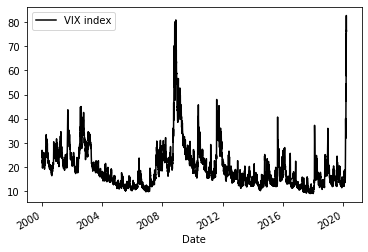

In [10]:
v_vix['Close'].plot(style='k', label='VIX index')
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [11]:
v_vix['Close']

2000-01-03    24.209999
2000-01-04    27.010000
2000-01-05    26.410000
2000-01-06    25.730000
2000-01-07    21.719999
                ...    
2020-03-12    75.470001
2020-03-13    57.830002
2020-03-16    82.690002
2020-03-17    75.910004
2020-03-18    76.449997
Name: Close, Length: 5084, dtype: float64

## Obtendo dados para Análise

#### Dados de International Exchanges: **SP500, DOW30, NYSE100, NASDAQ100, CBOE-VIX, etc.**  

<ul>
<li> estes dados são geralmente obtidos com periodicidade diária. Serão reamostrados para periodicidade semanal, usando a sexta-feira como data de referência da semana.
<li> para formação do candle semanal (open, high, low, close, volume), são tomados os seguintes valores na semana:
    <ol>
    <li>open: valor de abertura do primeiro dia útil da semana</li>
    <li>high: valor máximo da semana</li>
    <li>low: valor mínimo da semana</li>
    <li>close: valor de fechamento do último dia útil da semana</li>
    <li>volume: volume agregado da semana</li>
    </ol>
    
<li> Se o valor referente a sexta-feira for faltante, devido a um feriado (dia não útil) por exemplo, então a imputação ocorre substituindo o valor de sexta-feira pelo último dia útil daquela semana, ex. quinta-feira. O mesmo é feito para o primeiro dia útil da semana, caso este seja um dado faltante.
</ul>

#### Dados de Indicadores de Incerteza baseados em Análise de Sentimentos: **US-EPU Index, Twitter Index, etc.** 

<ul>
    <li> Estes dados geralmente são obtidos numa <b>granularidade diferente, geralmente mensal</b>. Assim, será necessário o uso de mecanismos de imputação (<b>Silvana</b>) para que eles também fiquem com periodicidade semanal. 
        
</ul>

### International Exchange Data

- Exemplo de Amostragem Semanal

### S&P500

In [12]:
v_sp500_week_start_date = v_sp500.resample('W-FRI').first()['Date']
v_sp500_week_end_date = v_sp500.resample('W-FRI').last()['Date']
v_sp500_num_of_weeks = min(len(v_sp500_week_start_date), len(v_sp500_week_end_date))

v_sp500_weekly_dict = {'date': [], 'open': [], 'high': [], 'low':[], 'close':[], 'volume':[], 'volatility':[]}

for i in range(v_sp500_num_of_weeks):
    v_sp500_week = v_sp500[v_sp500_week_start_date[i]:v_sp500_week_end_date[i]]
    if len(v_sp500_week) > 0:
        v_sp500_weekly_dict['date'].append(v_sp500_week_end_date.index[i])
        v_sp500_weekly_dict['open'].append(v_sp500_week['Open'][0])
        v_sp500_weekly_dict['close'].append(v_sp500_week['Close'][-1])
        v_sp500_weekly_dict['high'].append(v_sp500_week['High'].max())
        v_sp500_weekly_dict['low'].append(v_sp500_week['Low'].min())
        v_sp500_weekly_dict['volume'].append(v_sp500_week['Volume'].sum())
        if len(v_sp500_week) == 1:
            v_sp500_weekly_dict['volatility'].append(0.0)
        else:
            v_sp500_weekly_dict['volatility'].append(np.std(v_sp500_week['Close'].pct_change().dropna().values))    

v_sp500_weekly = pd.DataFrame.from_dict(v_sp500_weekly_dict)
v_sp500_weekly.index = pd.to_datetime(v_sp500_weekly['date'].values)
v_sp500_weekly.drop(['date'], axis=1, inplace=True)
#v_sp500_weekly = v_sp500_weekly[:-1]

v_sp500_weekly.info()


v_sp500_weekly.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1055 entries, 2000-01-07 to 2020-03-20
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        1055 non-null   float64
 1   high        1055 non-null   float64
 2   low         1055 non-null   float64
 3   close       1055 non-null   float64
 4   volume      1055 non-null   int64  
 5   volatility  1055 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 57.7 KB


,open,high,low,close,volume,volatility
2000-01-07,1469.250000,1478.000000,1377.680054,1441.469971,5343800000,0.023406
2000-01-14,1441.469971,1473.000000,1427.079956,1465.150024,5169700000,0.010543
2000-01-21,1465.150024,1465.709961,1438.540039,1441.359985,4455000000,0.003115
2000-01-28,1441.359985,1454.089966,1356.199951,1360.160034,5532100000,0.012306
2000-02-04,1360.160034,1435.910034,1350.140015,1424.369995,5205000000,0.005608


In [13]:
v_sp500_weekly.tail()

,open,high,low,close,volume,volatility
2020-02-21,3369.040039,3393.520020,3328.449951,3337.750000,15253460000,0.006230
2020-02-28,3257.610107,3259.810059,2855.840088,2954.219971,31535270000,0.016436
2020-03-06,2974.280029,3136.719971,2901.540039,2972.370117,29895510000,0.030301
2020-03-13,2863.889893,2882.590088,2478.860107,2711.020020,40521170000,0.074998
2020-03-20,2508.590088,2562.979980,2280.520020,2398.100098,24895820000,0.055893


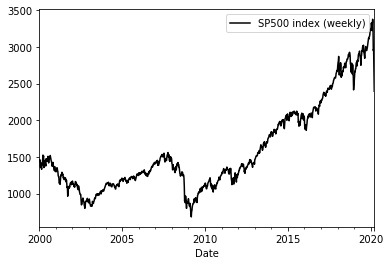

In [14]:
v_sp500_weekly['close'].plot(style='k', label='SP500 index (weekly)')
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

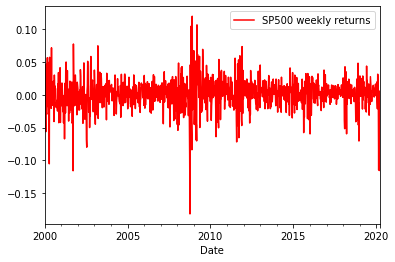

In [15]:
v_sp500_weekly['close'].pct_change().plot(style='r', label='SP500 weekly returns')
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [16]:
v_sp500_weekly['close'].pct_change()

2000-01-07         NaN
2000-01-14    0.016428
2000-01-21   -0.016237
2000-01-28   -0.056336
2000-02-04    0.047208
                ...   
2020-02-21   -0.012547
2020-02-28   -0.114907
2020-03-06    0.006144
2020-03-13   -0.087926
2020-03-20   -0.115425
Name: close, Length: 1055, dtype: float64

### CBOE-VIX

In [17]:
v_vix_week_start_date = v_vix.resample('W-FRI').first()['Date']
v_vix_week_end_date = v_vix.resample('W-FRI').last()['Date']
v_vix_num_of_weeks = min(len(v_vix_week_start_date), len(v_vix_week_end_date))

v_vix_weekly_dict = {'date': [], 'open': [], 'high': [], 'low':[], 'close':[], 'volatility':[]}

for i in range(v_vix_num_of_weeks):
    v_vix_week = v_vix[v_vix_week_start_date[i]:v_vix_week_end_date[i]]
    if len(v_vix_week) > 0:
        v_vix_weekly_dict['date'].append(v_vix_week_end_date.index[i])
        v_vix_weekly_dict['open'].append(v_vix_week['Open'][0])
        v_vix_weekly_dict['close'].append(v_vix_week['Close'][-1])
        v_vix_weekly_dict['high'].append(v_vix_week['High'].max())
        v_vix_weekly_dict['low'].append(v_vix_week['Low'].min())
        if len(v_vix_week) == 1:
            v_vix_weekly_dict['volatility'].append(0.0)
        else:
            v_vix_weekly_dict['volatility'].append(np.std(v_vix_week['Close'].pct_change().dropna().values))    

v_vix_weekly = pd.DataFrame.from_dict(v_vix_weekly_dict)
v_vix_weekly.index = pd.to_datetime(v_vix_weekly['date'].values)
v_vix_weekly.drop(['date'], axis=1, inplace=True)
#v_vix_weekly = v_vix_weekly[:-1]
v_vix_weekly.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1055 entries, 2000-01-07 to 2020-03-20
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        1055 non-null   float64
 1   high        1055 non-null   float64
 2   low         1055 non-null   float64
 3   close       1055 non-null   float64
 4   volatility  1055 non-null   float64
dtypes: float64(5)
memory usage: 49.5 KB


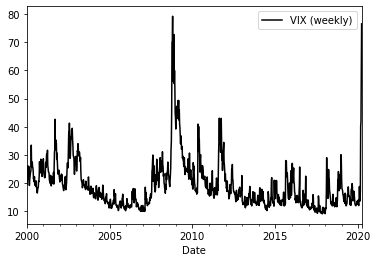

In [18]:
v_vix_weekly['close'].plot(style='k', label='VIX (weekly)')
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [19]:
v_vix_weekly['close']

2000-01-07    21.719999
2000-01-14    19.660000
2000-01-21    20.820000
2000-01-28    26.139999
2000-02-04    21.540001
                ...    
2020-02-21    17.080000
2020-02-28    40.110001
2020-03-06    41.939999
2020-03-13    57.830002
2020-03-20    76.449997
Name: close, Length: 1055, dtype: float64

### TO-DO: Completar para Outras Exchanges ... (apenas repetir o trecho de codigo)

## Uncertainty Indicator Data

- Exemplo de Amostragem Mensal

### US Equity Market Volatility Index

see __[US Equity Market Volatility Index
](http://www.policyuncertainty.com/EMV_monthly.html)__ for more details

This is a newspaper-based Equity Market Volatility (EMV) tracker that moves with the CBOE Volatility Index (VIX) 
and with the realized volatility of returns on the S&P500. 

There is also a Policy-Related EMV Tracker and a suite of more than 30 category-specific 
EMV trackers that quantify the importance of each category in the level of U.S. stock market volatility 
and its movements over time. The overall and category-specific EMV trackers 
are monthly and available from January 1985 to the present.

### - TO DO: necessário verificar a data em que o index mensal é reportado para sincronizar com as outras time series (semanais)


In [73]:
v_monthly_EMV_index =  pd.read_excel(v_directory + 'EMV_Data.xlsx') 
v_monthly_EMV_index = v_monthly_EMV_index[:-1]

v_monthly_EMV_index['Month'] = v_monthly_EMV_index['Month'].astype('str')
v_monthly_EMV_index['Year'] = v_monthly_EMV_index['Year'].astype('str')
s = pd.Series('', index=list(range(len(v_monthly_EMV_index))), dtype='str')
i = 0
for month in v_monthly_EMV_index['Month']:
    result =  month.split('.')
    if int(result[0]) <= 9:
        s[i] = result[1] + result[0]
    else:
        s[i] = result[0]
    i=i+1

v_monthly_EMV_index['Date'] = v_monthly_EMV_index['Year'] + '-' + s
v_monthly_EMV_index['Date'] = pd.to_datetime(v_monthly_EMV_index['Date'], format='%Y-%m')
v_monthly_EMV_index.index = v_monthly_EMV_index['Date'].values
v_monthly_EMV_index.sort_index(inplace=True)
v_monthly_EMV_index.drop(['Month', 'Year'], axis=1, inplace=True)
v_monthly_EMV_index.dropna(thresh=1, axis=0, inplace=True)

v_monthly_EMV_index.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 425 entries, 1985-01-01 to 2020-05-01
Data columns (total 45 columns):
 #   Column                                                            Non-Null Count  Dtype         
---  ------                                                            --------------  -----         
 0   Overall EMV Tracker                                               425 non-null    float64       
 1   Policy-Related EMV Tracker                                        425 non-null    float64       
 2   Infectious Disease EMV Tracker                                    425 non-null    float64       
 3   Macroeconomic News and Outlook EMV Tracker                        425 non-null    float64       
 4   Macro – Broad Quantity Indicators EMV Tracker                     425 non-null    float64       
 5   Macro – Inflation EMV Indicator                                   425 non-null    float64       
 6   Macro – Interest Rates EMV Tracker                     

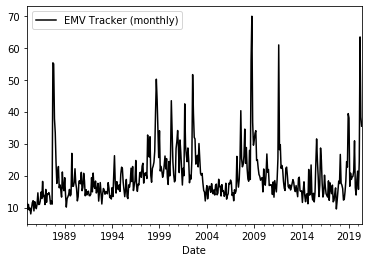

In [71]:
v_monthly_EMV_index['Overall EMV Tracker'].plot(style='k', label='EMV Tracker (monthly)')
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()



426